# Multidimensional scaling of antibody escape profiles
This Python Jupyter notebook performs multi-dimensional scaling of escape profiles to project the antibodies into two dimensions based on similarity of their escape profiles.

## Set up analysis
Import Python modules:

In [1]:
import itertools
import os

import adjustText

from dms_variants.constants import CBPALETTE

from IPython.display import display, HTML

import matplotlib
import matplotlib.pyplot as plt

import numpy

import pandas as pd

import seaborn

import sklearn.manifold

import yaml

Read the configuration file:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Create output directory:

In [3]:
os.makedirs(config['mds_dir'], exist_ok=True)

Extract from configuration what we will use as the site- and mutation-level metrics:

In [4]:
site_metric = config['site_metric']
mut_metric = config['mut_metric']

print(f"At site level, quantifying selection by {site_metric}")
print(f"At mutation level, quantify selection by {mut_metric}")

At site level, quantifying selection by site_total_escape_frac_epistasis_model
At mutation level, quantify selection by mut_escape_frac_epistasis_model


## Read samples and escape fractions
Read the escape fractions.
We only retain the **average** of the libraries for plotting here, not the individual libraries.
Also, we work in the full-Spike rather than RBD numbering, which means we use `label_site` as `site` (and so rename as such below):

In [5]:
print(f"Reading escape fractions from {config['escape_fracs']}")
escape_fracs = (pd.read_csv(config['escape_fracs'])
                .query('library == "average"')
                .drop(columns=['site', 'selection', 'library'])
                .rename(columns={'label_site': 'site'})
                )

Reading escape fractions from results/escape_scores/escape_fracs.csv


## Get antibody sets for each multidimensional scaling
We have manually specified configurations for the MDS plots in a YAML file.
We will do multi-dimensional scaling for each antibody/sera set specified in this file:

In [6]:
print(f"Reading MDS configuration from {config['mds_config']}")
with open(config['mds_config']) as f:
    mds_config = yaml.safe_load(f)
    
print(f"Reading the site color schemes from {config['site_color_schemes']}")
site_color_schemes = pd.read_csv(config['site_color_schemes'])

Reading MDS configuration from data/mds_config.yaml
Reading the site color schemes from data/site_color_schemes.csv


## Multidimensional scaling
Note that there are three main steps here:
 1. Calculate similarities between profiles of each antibody.
 2. Convert similarities to dissimilarities.
 3. Do multi-dimensional scaling and plot the results.

First, define a function to compute the similarity between all pairs of escape profiles in a data frame.
We calculate similarity as the dot product of the escape profiles for each pair of conditions, using the site-level metric and normalizing each profile so it's dot product with itself is one.
Importantly, we raise the site-level metric to the $p$ power in order to emphasize sites with large values (essentially a p-norm):

In [7]:
def escape_similarity(df, p=1):
    """Compute similarity between all pairs of conditions in `df`."""
    df = df[['condition', 'site', site_metric]].drop_duplicates()
    assert not df.isnull().any().any()
    
    conditions = df['condition'].unique()
    similarities = []
    for cond1, cond2 in itertools.product(conditions, conditions):
        similarity = (
            df
            .assign(metric=lambda x: x[site_metric]**p)
            .pivot_table(index='site', columns='condition', values='metric', fill_value=0)
            [list({cond1, cond2})]
            # for normalization: https://stackoverflow.com/a/58113206
            # to get norm: https://stackoverflow.com/a/47953601
            .transform(lambda x: x / numpy.linalg.norm(x, axis=0))
            .assign(similarity=lambda x: x[cond1] * x[cond2])
            ['similarity']
            )
        assert similarity.notnull().all()  # make sure no sites have null values
        similarities.append(similarity.sum())  # sum of similarities over sites
    return pd.DataFrame(numpy.array(similarities).reshape(len(conditions), len(conditions)),
                        columns=conditions, index=conditions)

Define function to compute dissimilarity $d$ from the similarity $s$.
Options are:
  - **one_minus**: $d = 1 - s$
  - **minus_log**: $d = -\ln s$

In [8]:
def dissimilarity(similarity, method='one_minus'):
    if method == 'one_minus':
        return 1 - similarity
    elif method == 'minus_log':
        return -numpy.log(similarity)
    else:
        raise ValueError(f"invalid `method` {method}")

Now compute the similarities and dissimilarities, and do the multidimensional scaling [as described here](https://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html#sphx-glr-auto-examples-manifold-plot-mds-py).
We do this just for the antibody combinations for which such a plot is specified in the escape profiles configuration file.
We then plot the multidimensional scaling, using [adjustTexts](https://adjusttext.readthedocs.io/) to repel the labels and following [here](https://stackoverflow.com/q/56337732) to draw pie charts that color the points according to the site-coloring scheme if specified in configuration.
These pie charts color by the fraction of the squared site escape apportioned to each site category.


Making plot Rockefeller_v_pub, which has the following antibodies:
['CB6_400', 'LY-CoV555_400', 'REGN10933_400', 'REGN10987_400', 'CR3022_400', 'COV2-2677_400', 'COV2-2082_400', 'COV2-2094_400', 'COV2-2165_400', 'COV2-2832_400', 'COV2-2479_400', 'COV2-2050_400', 'COV2-2096_400', 'COV2-2499_400', 'C105_400', 'C144_400', 'C002_400', 'C121_400', 'C135_400', 'C110_400', 'COV2-2196_400', 'COV2-2130_400']
Using the barnes_classes site color scheme
Saving plot to results/multidimensional_scaling/Rockefeller_v_pub_mds.pdf


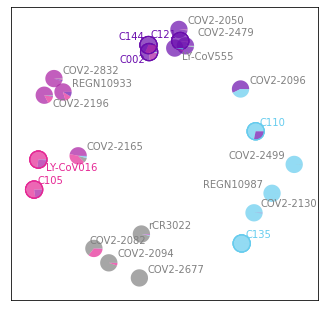


Making plot NY_sera_antibodies, which has the following antibodies:
['C105_400', 'C144_400', 'C002_400', 'C121_400', 'C135_400', 'C110_400', 'COV-021_500', 'COV-047_200', 'COV-057_50', 'COV-072_200', 'COV-107_80']
Using condition-level color scheme in column class_color of data/mds_color_schemes.csv
Saving plot to results/multidimensional_scaling/NY_sera_antibodies_mds.pdf


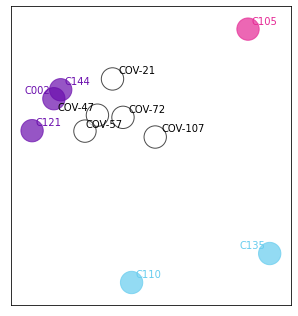


Making plot NY_sera_all_mAbs, which has the following antibodies:
['CB6_400', 'LY-CoV555_400', 'REGN10933_400', 'REGN10987_400', 'CR3022_400', 'COV2-2677_400', 'COV2-2082_400', 'COV2-2094_400', 'COV2-2165_400', 'COV2-2832_400', 'COV2-2479_400', 'COV2-2050_400', 'COV2-2096_400', 'COV2-2499_400', 'C105_400', 'C144_400', 'C002_400', 'C121_400', 'C135_400', 'C110_400', 'COV2-2196_400', 'COV2-2130_400', 'COV-021_500', 'COV-047_200', 'COV-057_50', 'COV-072_200', 'COV-107_80', '23_d21_1250', '23_d45_1250', '23_d120_500', '1C_d26_200', '1C_d113_200', '24C_d32_200', '24C_d104_200', '6C_d33_500', '6C_d76_500', '22C_d28_200', '22C_d104_200', '25C_d48_200', '25C_d115_80', '25_d18_500', '25_d94_200', '12C_d61_160', '12C_d152_80', '23C_d26_80', '23C_d102_80', '13_d15_200', '13_d121_1250', '7C_d29_500', '7C_d103_200']
Using condition-level color scheme in column class_color of data/mds_color_schemes_new.csv
Saving plot to results/multidimensional_scaling/NY_sera_all_mAbs_mds.pdf


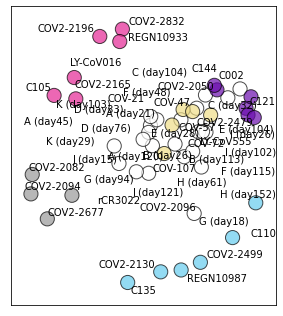

In [9]:
# which method do we use to compute dissimilarity?
dissimilarity_method = 'one_minus'

# do we also plot similarity / dissimilarity matrices?
plot_similarity = False

# function to draw colored pie for each point.
def draw_pie(dist, xpos, ypos, size, ax, colors, alpha, circle_color):
    """Based on this: https://stackoverflow.com/q/56337732"""
    # for incremental pie slices
    cumsum = numpy.cumsum(dist)
    cumsum = cumsum / cumsum[-1]
    pie = [0] + cumsum.tolist()

    assert len(colors) == len(dist)
    for r1, r2, color in zip(pie[:-1], pie[1:], colors):
        angles = numpy.linspace(2 * numpy.pi * r1, 2 * numpy.pi * r2)
        x = [0] + numpy.cos(angles).tolist()
        y = [0] + numpy.sin(angles).tolist()

        xy = numpy.column_stack([x, y])

        ax.scatter([xpos], [ypos], marker=xy, s=size, facecolors=color, alpha=alpha, edgecolors='none')
        ax.scatter(xpos, ypos, marker='o', s=size, edgecolors=circle_color,
                   facecolors='none', alpha=alpha)

    return ax

# loop over combinations to plot
for name, specs in mds_config.items():
    
    # get data frame with just the conditions we want to plot, also re-naming them
    conditions_to_plot = list(specs['conditions'].keys())
    print(f"\nMaking plot {name}, which has the following antibodies:\n{conditions_to_plot}")
    assert len(conditions_to_plot) == len(set(specs['conditions'].values()))
    assert set(conditions_to_plot).issubset(set(escape_fracs['condition']))
    df = (escape_fracs
          .query('condition in @conditions_to_plot')
          .assign(condition=lambda x: x['condition'].map(specs['conditions']))
          )
    
    # compute similarities and dissimilarities
    similarities = escape_similarity(df)
    dissimilarities = similarities.applymap(lambda x: dissimilarity(x, method=dissimilarity_method))
    conditions = df['condition'].unique()
    assert all(conditions == similarities.columns) and all(conditions == similarities.index)
    n = len(conditions)
    
    # plot similarities
    if plot_similarity:
        for title, data in [('Similarities', similarities), ('Dissimilarities', dissimilarities)]:
            fig, ax = plt.subplots(figsize=(0.8 * n, 0.7 * n))
            _ = seaborn.heatmap(data, annot=True, ax=ax)
            plt.title(f"{title} for {name}", size=16)
            plt.show(fig)
            plt.close(fig)
    
    # use multidimensional scaling to get locations of antibodies
    mds = sklearn.manifold.MDS(n_components=2,
                               metric=True,
                               max_iter=3000,
                               eps=1e-6,
                               random_state=1 if 'random_state' not in specs else specs['random_state'],
                               dissimilarity='precomputed',
                               n_jobs=1)
    locs = mds.fit_transform(dissimilarities)
    
    # get the colors for each point if relevant
    color_scheme = specs['color_scheme']
    if isinstance(color_scheme, list):
        color_csv, color_col = color_scheme
        print(f"Using condition-level color scheme in column {color_col} of {color_csv}")
        dists = [[1] for condition in conditions]
        condition_to_color = pd.read_csv(color_csv).set_index('condition')[color_col].to_dict()
        if set(conditions) != set(condition_to_color):
            raise ValueError(f"{color_scheme} doesn't have colors for expected conditions: {conditions}")
        colors = [[condition_to_color[condition]] for condition in conditions]
    elif color_scheme in site_color_schemes.columns:
        print(f"Using the {color_scheme} site color scheme")
        site_colors = site_color_schemes.set_index('site')[color_scheme].to_dict()
        df = df.assign(color=lambda x: x['site'].map(site_colors))
        dists = []
        colors = []
        for condition, condition_df in (
                df
                [['condition', 'color', 'site', site_metric]]
                .drop_duplicates()
                .assign(site_metric2=lambda x: x[site_metric]**2)  # color in proportion to **square** of site escape
                .groupby(['condition', 'color'])
                .aggregate(tot_escape=pd.NamedAgg('site_metric2', 'sum'))
                .reset_index()
                .sort_values('tot_escape', ascending=False)
                .assign(condition=lambda x: pd.Categorical(x['condition'], conditions, ordered=True))
                .groupby('condition', sort=True)
                ):
            dists.append(condition_df['tot_escape'].tolist())
            colors.append(condition_df['color'].tolist())
    else:
        print(f"Coloring all points {color_scheme}")
        dists = [[1] for conditition in conditions]
        colors = [[color_scheme] for condition in conditions]
        
    # get circle / label colors
    if 'default_circle_color' in specs:
        default_circle_color = specs['default_circle_color']
    else:
        default_circle_color = 'none'
    if 'default_label_color' in specs:
        default_label_color = specs['default_label_color']
    else:
        default_label_color = 'black'
    circle_colors = []
    label_colors = []
    for condition in conditions:
        if 'circle_colors' in specs and condition in specs['circle_colors']:
            circle_colors.append(specs['circle_colors'][condition])
        else:
            circle_colors.append(default_circle_color)
        if 'label_colors' in specs and condition in specs['label_colors']:
            label_colors.append(specs['label_colors'][condition])
        else:
            label_colors.append(default_label_color)
    
    # plot the multidimensional scaling result
    plot_size = 4 if 'plot_size' not in specs else specs['plot_size']
    fig, ax = plt.subplots(figsize=(plot_size, plot_size))
    xs = locs[:, 0]
    ys = locs[:, 1]
    for x, y, dist, color, circle_color in zip(xs, ys, dists, colors, circle_colors):
        draw_pie(dist, x, y,
                 size=300 if 'pie_size' not in specs else specs['pie_size'],
                 ax=ax,
                 colors=color,
                 alpha=0.7 if 'pie_alpha' not in specs else specs['pie_alpha'],
                 circle_color=circle_color,
                 )
    ax.set_aspect('equal', adjustable='box')  # same distance on both axes
    ax.set_xticks([])  # no x-ticks
    ax.set_yticks([])  # no y-ticks
    ax.margins(0.09)  # increase padding from axes
    texts = [plt.text(x, y, label, color=color) for x, y, label, color
             in zip(xs, ys, conditions, label_colors)]
    adjustText.adjust_text(texts,
                           x=xs,
                           y=ys,
                           expand_points=(1.2, 1.6) if 'expand_points' not in specs
                                         else specs['expand_points'],
                           )
    plotfile = os.path.join(config['mds_dir'], f"{name}_mds.pdf")
    print(f"Saving plot to {plotfile}")
    fig.savefig(plotfile, bbox_inches='tight')
    plt.show(fig)
    plt.close(fig)